In [1]:
# Kaggle API credentials
import os
os.environ['KAGGLE_USERNAME'] = "bilalxahmd"
os.environ['KAGGLE_KEY'] = "3ce56f1cd6d4159b67516d4485755fa6"

In [2]:
# Downloading dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [30]:
# Paths
train_path = '/content/chest_xray/train'
test_path = '/content/chest_xray/test'
val_path = '/content/chest_xray/val'

In [17]:
def load_data(data_dir):
    data, labels = [], []
    for label in ['PNEUMONIA', 'NORMAL']:
        path = os.path.join(data_dir, label)
        class_num = 0 if label == 'PNEUMONIA' else 1
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_arr is not None:  # Ensure valid image is loaded
                    resized_arr = cv2.resize(img_arr, (150, 150)) / 255.0
                    data.append(resized_arr)
                    labels.append(class_num)
            except Exception as e:
                print(f"Error loading image {img}: {e}")

    if len(data) > 0:
        return np.array(data).reshape(-1, 150, 150, 1), np.array(labels)
    else:
        raise ValueError("No valid images found in the dataset.")


In [31]:
X_train, y_train = load_data(train_path)
X_test, y_test = load_data(test_path)
X_val, y_val = load_data(val_path)

In [32]:
# Check imbalance
from collections import Counter
print(f"Class distribution (before augmentation): {Counter(y_train)}")

Class distribution (before augmentation): Counter({0: 3875, 1: 1341})


In [33]:
# Data augmentation (only for NORMAL class)
normal_count = np.sum(y_train == 1)
pneumonia_count = np.sum(y_train == 0)

In [34]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


In [35]:
if normal_count < pneumonia_count:
    diff = pneumonia_count - normal_count
    normal_images = X_train[y_train == 1]
    augmented_images = []
    for img in datagen.flow(normal_images, batch_size=1):
        augmented_images.append(img[0])
        if len(augmented_images) >= diff:
            break

    X_train = np.concatenate((X_train, np.array(augmented_images)))
    y_train = np.concatenate((y_train, np.ones(diff)))

In [36]:
print(f"Class distribution (after augmentation): {Counter(y_train)}")

Class distribution (after augmentation): Counter({0.0: 3875, 1.0: 3875})


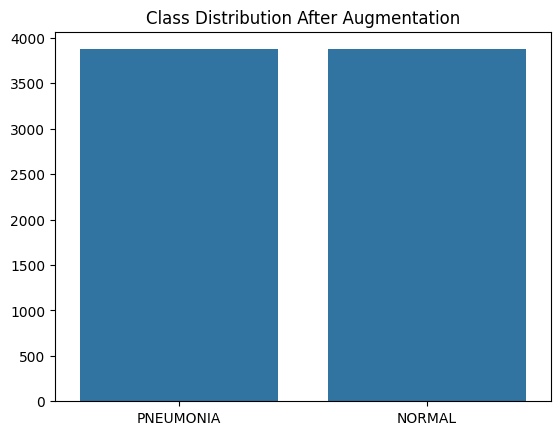

In [37]:
# Visualization
sns.barplot(x=['PNEUMONIA', 'NORMAL'], y=[np.sum(y_train == 0), np.sum(y_train == 1)])
plt.title('Class Distribution After Augmentation')
plt.show()


In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# CNN model
def build_model():
    model = Sequential()
    model.add(Conv2D(32, (3,3), strides=1, padding='same', activation='relu', input_shape=(150,150,1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=2, padding='same'))

    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=2, padding='same'))

    model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=2, padding='same'))

    model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=2, padding='same'))

    model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [39]:
model = build_model()

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)                │              

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [40]:
# Learning rate reduction
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)

In [41]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=12,
    validation_data=datagen.flow(X_val, y_val),
    callbacks=[learning_rate_reduction]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 732s 3s/step - accuracy: 0.7916 - loss: 0.9106 - val_accuracy: 0.5000 - val_loss: 16.9986 - learning_rate: 0.0010
Epoch 2/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 704s 3s/step - accuracy: 0.9093 - loss: 0.2523 - val_accuracy: 0.5000 - val_loss: 25.0086 - learning_rate: 0.0010
Epoch 3/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 698s 3s/step - accuracy: 0.9258 - loss: 0.2110 - val_accuracy: 0.5625 - val_loss: 2.4755 - learning_rate: 0.0010
Epoch 4/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 696s 3s/step - accuracy: 0.9443 - loss: 0.1589 - val_accuracy: 0.8125 - val_loss: 0.5000 - learning_rate: 0.0010
Epoch 5/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 698s 3s/step - accuracy: 0.9458 - loss: 0.1529 - val_accuracy: 0.5000 - val_loss: 6.9024 - learning_rate: 0.0010
Epoch 6/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9529 - loss: 0.1655
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
243/243 ━━━━━━━━━━━━━━━━━━━━ 689s 3s/step - accuracy: 0.9529 - loss: 0.1

In [42]:
# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 858ms/step - accuracy: 0.9467 - loss: 0.1838
Test Accuracy: 87.82%


In [43]:
# Classification report
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 763ms/step
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       390
           1       0.95      0.71      0.81       234

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.89      0.88      0.87       624



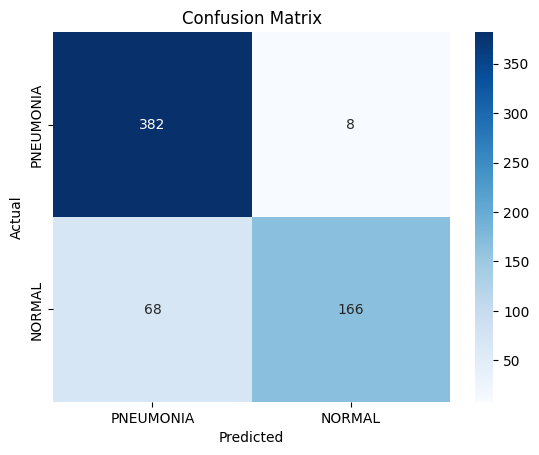

In [44]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['PNEUMONIA', 'NORMAL'], yticklabels=['PNEUMONIA', 'NORMAL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


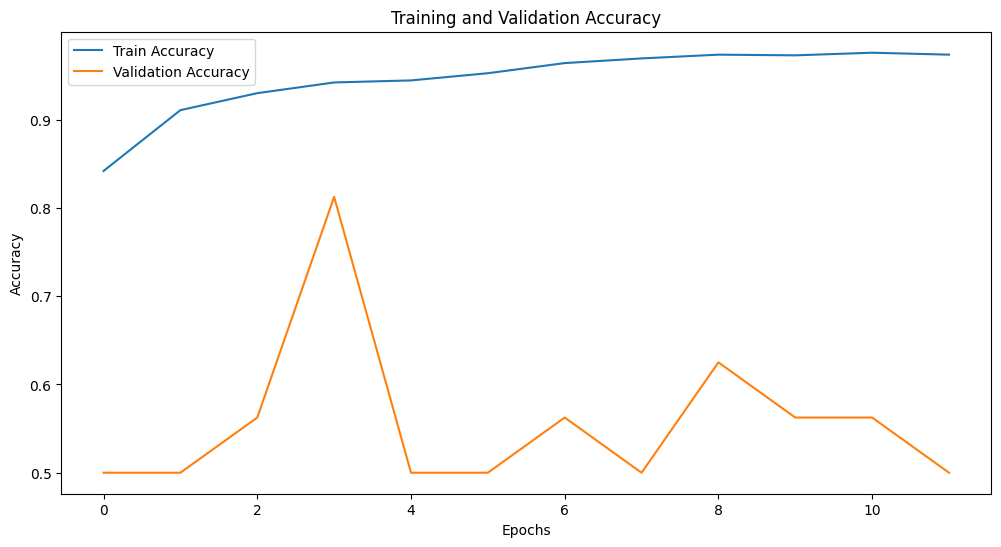

In [45]:
# Accuracy and Loss plot
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

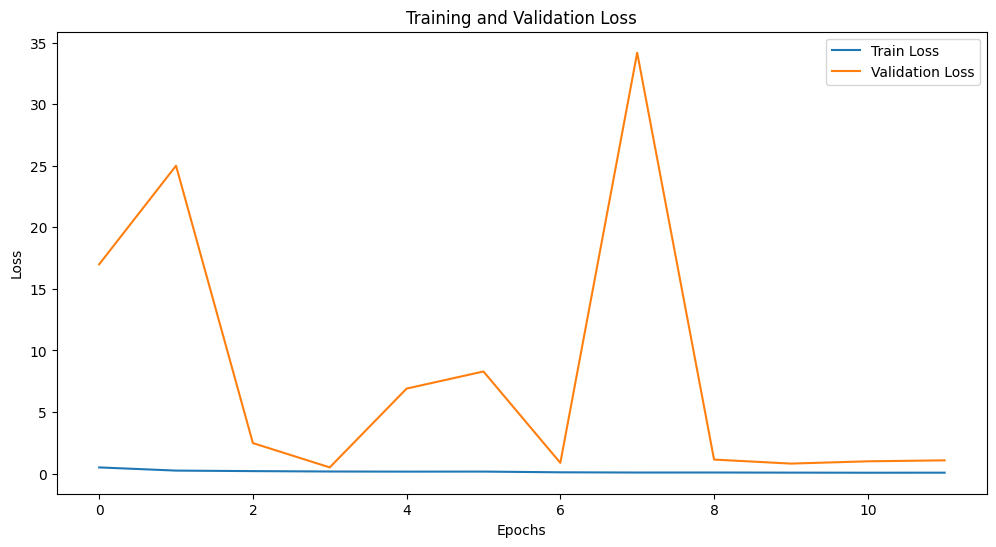

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
